In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Subset
import cv2
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_loc = "drive/MyDrive/Columbia Research/Bose Einstein Condensation ML/data/rotating_gs"
model_loc = "drive/MyDrive/Columbia Research/Bose Einstein Condensation ML/models"

#Wandb constants
entity="HPML-final-team"
project="HPML Final Project"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%pip install wandb

In [4]:
import wandb
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jcl2259 (HPML-final-team) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
train_data = np.load(f"{data_loc}/train.npz")
val_data = np.load(f"{data_loc}/val.npz")
test_data = np.load(f"{data_loc}/test.npz")

# Visualize Data

In [6]:
print(f"Size of train densities: {train_data['densities'].shape}")
print(f"Size of val densities: {val_data['densities'].shape}")
print(f"Size of test densities: {test_data['densities'].shape}")
print()
print(f"Size of train phase gradients: {train_data['phase_gradients'].shape}")
print(f"Size of val phase gradients: {val_data['phase_gradients'].shape}")
print(f"Size of test phase gradients: {test_data['phase_gradients'].shape}")
print()


Size of train densities: (1008, 200, 200)
Size of val densities: (336, 200, 200)
Size of test densities: (336, 200, 200)

Size of train phase gradients: (1008, 2, 200, 200)
Size of val phase gradients: (336, 2, 200, 200)
Size of test phase gradients: (336, 2, 200, 200)



In [39]:
# Visualize an example
idx = 1
fig, axes = plt.subplots(2, 2, figsize = (10, 10))
axes[0, 0].imshow(train_data['densities'][idx], cmap='gray')
axes[0, 1].imshow(train_data['phase_gradients'][idx, 0])
axes[1, 0].imshow(train_data['phase_gradients'][idx, 1])
axes[1, 1].imshow(1 - train_data['masks'][idx, 0], cmap = 'gray')

axes[0, 0].set_title("Density")
axes[0, 1].set_title("x phase grad")
axes[1, 0].set_title("y phase grad")
axes[1, 1].set_title("Mask (valid region)")

plt.suptitle("Training Example")

#log to weights and biases
wandb.init(name = "image_snapshots", project = project, entity = entity)
wandb.log({"training_example": wandb.Image(fig)})
plt.close(fig)

# Custom Datasets/Dataloaders

In [17]:
class BecDataset(Dataset):
    def __init__(self, densities, phase_grads, masks, log_eps=1e-9, augment=True):
        """
        densities: (N, W, W)
        phase_grads: (N, 2, W, W)
        masks: (N, 2, W, W)
        """
        self.densities = torch.tensor(densities).float().unsqueeze(1)
        self.phase_grads = torch.tensor(phase_grads).float()
        self.masks = torch.tensor(masks).float()
        self.log_eps = log_eps
        self.augment = augment

    def __len__(self):
        return self.densities.size(0)

    def _rotate90(self, density, phase_grad, mask, k):
        """Rotate by k * 90 degrees."""
        if k == 0:
            return density, phase_grad, mask

        # Rotate scalar fields
        density = torch.rot90(density, k, dims=(1, 2))
        mask = torch.rot90(mask, k, dims=(1, 2))

        # Rotate vector field components
        gx, gy = phase_grad[0], phase_grad[1]

        gx = torch.rot90(gx, k, dims=(0, 1))
        gy = torch.rot90(gy, k, dims=(0, 1))

        if k == 1:        # 90°: (gx, gy) -> (gy, -gx)
            phase_grad = torch.stack([gy, -gx], dim=0)
        elif k == 2:      # 180°: (gx, gy) -> (-gx, -gy)
            phase_grad = torch.stack([-gx, -gy], dim=0)
        elif k == 3:      # 270°: (gx, gy) -> (-gy, gx)
            phase_grad = torch.stack([-gy, gx], dim=0)

        return density, phase_grad, mask

    def __getitem__(self, idx):
        density = torch.log(self.densities[idx] + self.log_eps)
        phase_grad = self.phase_grads[idx].clone()
        mask = self.masks[idx].clone()

        if self.augment:
            k = torch.randint(low=0, high=4, size=(1,)).item()  # 0,1,2,3
            density, phase_grad, mask = self._rotate90(
                density, phase_grad, mask, k
            )

        return density, phase_grad, mask

train_dataset = BecDataset(train_data['densities'], train_data['phase_gradients'], train_data['masks'], augment = False)
val_dataset = BecDataset(val_data['densities'], val_data['phase_gradients'], val_data['masks'], augment = False)
test_dataset = BecDataset(test_data['densities'], test_data['phase_gradients'], test_data['masks'], augment = False)

In [18]:
# Create corresponding dataloaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 2)
val_loader = DataLoader(val_dataset, num_workers = 2)
test_loader = DataLoader(test_dataset, num_workers = 2)

# UNET Definition

In [12]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels, momentum = 0.2),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels, momentum = 0.2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True, add_skip = True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        self.add_skip = add_skip
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        if self.add_skip:
            x = torch.cat([x2, x1], dim=1)
            #print(f"dim after concatenation: {x.shape}")
        else:
            x = x1
        #print(f"Running conv2d with {self.conv.double_conv[0].in_channels} in_channels, {self.conv.double_conv[-3].out_channels} out_channels")
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, channels, bilinear=True, add_skip = True, out_channels = 1, wrap_angles = False, verbose=False):
        super(UNet, self).__init__()
        self.channels = channels
        self.bilinear = bilinear
        self.verbose = verbose
        self.wrap_angles = wrap_angles

        self.inc = DoubleConv(channels[0], channels[1])
        if add_skip:
            #Repeat the final layer to add a skip connection in that layer
            self.downs = nn.ModuleList([Down(channels[i], channels[i+1]) for i in range(1, len(channels)-1)] +
                                       [Down(channels[-1], channels[-1])])
            self.ups = nn.ModuleList([Up(2*channels[i+1], channels[i], bilinear, add_skip) for i in range(len(channels)-2, 0, -1)] +
                                     [Up(2* channels[1], channels[1], bilinear, add_skip)])
        else:
            self.downs = nn.ModuleList([Down(channels[i], channels[i+1]) for i in range(1, len(channels)-1)])
            self.ups = nn.ModuleList([Up(channels[i+1], channels[i], bilinear, add_skip) for i in range(len(channels)-2, 0, -1)])
        self.outc = OutConv(channels[1], out_channels)

    def forward(self, x):
        x_stages = [self.inc(x)]
        if self.verbose:
            print(f"x1 shape: {x_stages[-1].shape}")

        for down in self.downs:
            x_stages.append(down(x_stages[-1]))
            if self.verbose:
                print(f"Down stage shape: {x_stages[-1].shape}")

        x = x_stages.pop()
        for up in self.ups:
            x_popped = x_stages.pop()
            if self.verbose:
                print(f"Up stage shape 1: {x.shape}, popped {x_popped.shape}")
            x = up(x, x_popped)
            if self.verbose:
                print(f"Up stage shape: {x.shape}")

        x = self.outc(x)
        if self.verbose:
            print(f"Output shape: {x.shape}")

        #Make between -pi and pi
        if self.wrap_angles:
            x = -F.relu(x + torch.pi) + 2*torch.pi
            x = F.relu(x) - torch.pi
        return x

In [13]:
#Example usage, showing the channel sizes
unet_8 = UNet(channels = [1, 8, 16, 32, 64, 128, 256, 512], out_channels = 2, verbose = True)
dataiter = iter(train_loader)
images, labels, masks = next(dataiter)
print(images.shape)

output = unet_8(images);

NameError: name 'train_loader' is not defined

# Training


In [22]:
def predict(dataloader, model, device="cpu"):
    """
    Return *torch tensors* for inputs, predictions, ground_truths, masks, and errors.
    """
    model.eval()
    inputs_list = []
    predictions = []
    ground_truths = []
    masks = []
    with torch.no_grad():
        for inputs, targets, mask_batch in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            mask_batch = mask_batch.to(device)
            preds = model(inputs)

            inputs_list.append(inputs)
            predictions.append(preds)
            ground_truths.append(targets)
            masks.append(mask_batch)

    # Concatenate tensors over batch dimension
    return (
        torch.cat(inputs_list, dim=0),
        torch.cat(predictions, dim=0),
        torch.cat(ground_truths, dim=0),
        torch.cat(masks, dim=0),
    )

def train_model(train_loader, model, loss_fn, optimizer, epochs=10, device="cpu", run = None):

    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for inputs, targets, masks in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets, masks)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Run validation using torch-level predict()
        _, predictions, ground_truths, masks = predict(
            val_loader, model, device=device
        )
        val_loss = loss_fn(predictions, ground_truths, masks).item()

        if run is not None:
            run.log({'train_loss': total_loss / len(train_loader), 'val_loss': val_loss})

        print(f"Epoch {epoch+1} Train Loss: {total_loss / len(train_loader)}, Val Loss: {val_loss}")

#Custom Loss function
#Ignores losses for masked out regions (mask = 1), as these are
#Low density regions and we don't care whether we get them right or not

def mse_with_mask(outputs, targets, masks, keep_first_dim = False):
    if keep_first_dim:
        return torch.mean(((outputs-targets)**2)*(1-masks), dim = (-1, -2, -3))
    else:
        return torch.mean(((outputs-targets)**2)*(1-masks))

In [ ]:
lr = 1e-3
channels = [1, 8, 16, 32, 64, 128, 256, 512]
n_epochs = 50
optimizer_arr = ["Adam", "AdamW", "SGD"]
for optimizer_name in optimizer_arr:
    print(f"Training with {optimizer_name}")
    run = wandb.init(
        name = f"optimizer_{optimizer_name}_3",
        entity=entity,

        project=project,

        config={
            "learning_rate": lr,
            "epochs": n_epochs,
            "channels": channels,
            "optimizer": optimizer_name,
        },
    )

    unet_8 = UNet(channels = channels, out_channels = 2)
    if optimizer_name == "Adam":
        optimizer = optim.Adam(unet_8.parameters(), lr=lr)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(unet_8.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(unet_8.parameters(), lr=lr)

    train_model(train_loader, unet_8, mse_with_mask, optimizer, epochs=n_epochs, device=device, run = run)

Training with Adam


train_loss,█▇▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,0.01291
val_loss,0.0134


Epoch 1 Train Loss: 0.01098047280758028, Val Loss: 0.008950143121182919
Epoch 2 Train Loss: 0.005769467199339517, Val Loss: 0.0052275145426392555
Epoch 3 Train Loss: 0.004648329085847806, Val Loss: 0.004066393710672855
Epoch 4 Train Loss: 0.003744320038499104, Val Loss: 0.003534668358042836
Epoch 5 Train Loss: 0.0033688979289893594, Val Loss: 0.0033598451409488916
Epoch 6 Train Loss: 0.0028509029911624063, Val Loss: 0.002519315807148814
Epoch 7 Train Loss: 0.002523353822263224, Val Loss: 0.0023461496457457542
Epoch 8 Train Loss: 0.0022706072380219307, Val Loss: 0.0029150941409170628
Epoch 9 Train Loss: 0.0022400315113676092, Val Loss: 0.0023391861468553543
Epoch 10 Train Loss: 0.001999073825399613, Val Loss: 0.0022946232929825783
Epoch 11 Train Loss: 0.0020267251751474326, Val Loss: 0.0018359266687184572
Epoch 12 Train Loss: 0.0018483849486247415, Val Loss: 0.0017755931476131082
Epoch 13 Train Loss: 0.0017537209473269444, Val Loss: 0.0022759679704904556
Epoch 14 Train Loss: 0.001731680

train_loss,█▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,0.00082
val_loss,0.00092


Epoch 1 Train Loss: 0.011514146815955875, Val Loss: 0.010488070547580719
Epoch 2 Train Loss: 0.004912593671756368, Val Loss: 0.004128954838961363
Epoch 3 Train Loss: 0.0036763692522303218, Val Loss: 0.003766293404623866
Epoch 4 Train Loss: 0.003021170982965342, Val Loss: 0.0027105631306767464
Epoch 5 Train Loss: 0.002536225370094476, Val Loss: 0.002390364184975624
Epoch 6 Train Loss: 0.002312660480605527, Val Loss: 0.0022993325255811214
Epoch 7 Train Loss: 0.002107553366970803, Val Loss: 0.002118172822520137
Epoch 8 Train Loss: 0.002034281515368512, Val Loss: 0.0018777947407215834
Epoch 9 Train Loss: 0.001945026110791202, Val Loss: 0.0017841003136709332
Epoch 10 Train Loss: 0.0017504707174671311, Val Loss: 0.0017293730052188039
Epoch 11 Train Loss: 0.001648718745277692, Val Loss: 0.0015447040786966681
Epoch 12 Train Loss: 0.0015799180615604634, Val Loss: 0.0015704766847193241
Epoch 13 Train Loss: 0.0015085275721041457, Val Loss: 0.0015527521027252078
Epoch 14 Train Loss: 0.001438392664

train_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,0.00067
val_loss,0.00077


Epoch 1 Train Loss: 0.06151109301145115, Val Loss: 0.04255456477403641
Epoch 2 Train Loss: 0.03699186555893412, Val Loss: 0.03605784848332405
Epoch 3 Train Loss: 0.032755068784195276, Val Loss: 0.03286230191588402
Epoch 4 Train Loss: 0.030495242126995607, Val Loss: 0.030725622549653053
Epoch 5 Train Loss: 0.028716254033266553, Val Loss: 0.02927505411207676
Epoch 6 Train Loss: 0.02726434019675094, Val Loss: 0.02774784155189991
Epoch 7 Train Loss: 0.025974628131186204, Val Loss: 0.026345444843173027
Epoch 8 Train Loss: 0.024805967186001084, Val Loss: 0.02538604848086834
Epoch 9 Train Loss: 0.02404489413288141, Val Loss: 0.025324134156107903
Epoch 10 Train Loss: 0.02325176629459574, Val Loss: 0.02404901571571827
Epoch 11 Train Loss: 0.022551592572459152, Val Loss: 0.02322954311966896
Epoch 12 Train Loss: 0.022053576806294068, Val Loss: 0.02274123765528202
Epoch 13 Train Loss: 0.021390014564588902, Val Loss: 0.02212034910917282
Epoch 14 Train Loss: 0.020729822838412865, Val Loss: 0.0214078

# Test Set Evaluation

In [54]:
# Load saved model from specific optimizer
optimizer_name = "AdamW"
unet_8 = torch.load(f"{model_loc}/unet_8_{optimizer_name}.pt", weights_only = False)
#

In [55]:
# Get test predictions
inputs, predictions, truths, masks = predict(test_loader, unet_8, device = device)
errors = mse_with_mask(predictions, truths, masks, keep_first_dim = True)

print(f"Error on the testing set: {errors.mean()}")

Error on the testing set: 0.0010630630422383547


In [56]:
# Convert to numpy arrays
inputs = inputs.cpu().numpy()
predictions = predictions.cpu().numpy()
truths = truths.cpu().numpy()
masks = masks.cpu().numpy()
errors = errors.cpu().numpy()

In [57]:
# Visualize a prediction
idx = 100
vmin = truths.min()
vmax = truths.max()
fig, axes = plt.subplots(2, 2, figsize = (10, 10))

axes[0, 0].imshow(truths[idx, 0], vmin = vmin, vmax = vmax)
axes[0, 1].imshow(predictions[idx, 0] * (1 - masks[idx, 0]), vmin = vmin, vmax = vmax)
axes[1, 0].imshow(truths[idx, 1], vmin = vmin, vmax = vmax)
axes[1, 1].imshow(predictions[idx, 1] * (1 - masks[idx, 0]), vmin = vmin, vmax = vmax)

axes[0, 0].set_title("GT x phase grad")
axes[0, 1].set_title(f"ML x phase grad {optimizer_name}")
axes[1, 0].set_title("GT y phase grad")
axes[1, 1].set_title(f"ML y phase grad {optimizer_name}")

# Log to wandb
#log to weights and biases
wandb.init(id = "1ttzvc4j", project = project, entity = entity, resume = "allow")
wandb.log({f"{optimizer_name}_prediction": wandb.Image(fig)})
plt.close(fig)

Text(0, 0.5, 'Frequency')

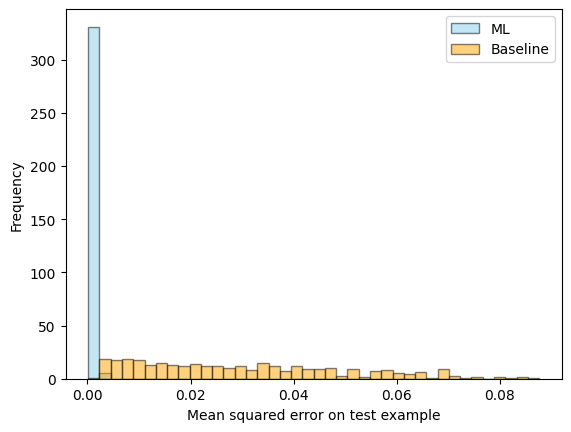

In [ ]:
# Histogram of model test set errors and baseline errors.
baseline_errors = np.var(truths, axis = (-1, -2, -3))
all_errors = np.concatenate([errors, baseline_errors])

bin_edges = np.histogram_bin_edges(all_errors, bins=40)
plt.hist(errors, alpha = 0.5, bins = bin_edges, label = "ML", color='skyblue', edgecolor='black')
plt.hist(baseline_errors, alpha = 0.5, bins = bin_edges, label = "Baseline", color='orange', edgecolor='black')
plt.legend()
plt.xlabel("Mean squared error on test example")
plt.ylabel("Frequency")

In [58]:
wandb.finish()

# Calculate Circulations

In [ ]:
def find_path_integral(gx, gy, mask, path):
    sum = np.zeros(len(gx))
    mask_sum = np.zeros(len(gx))
    for i in range(len(path)):
        curr_y, curr_x = path[i]
        next_y, next_x = path[(i + 1)%len(path)]
        dx = next_x - curr_x
        dy = next_y - curr_y

        dgx = 0 if dx >= 0 else dx
        dgy = 0 if dy >= 0 else dy
        assert abs(dx) < 2 and abs(dy) < 2
        if abs(dx) == 1 and abs(dy) == 1:
            sum += gx[..., curr_y, curr_x + dgx] * dx + gy[..., curr_y + dgy, next_x] * dy
            mask_sum += mask[..., curr_y, curr_x + dgx] + mask[..., curr_y + dgy, next_x]
        elif abs(dx) == 1:
            sum += gx[..., curr_y , curr_x + dgx] * dx
            mask_sum += mask[..., curr_y, curr_x + dgx]
        elif abs(dy) == 1:
            sum += gy[..., curr_y + dgy, curr_x] * dy
            mask_sum += mask[..., curr_y + dgy, curr_x]

    sum[mask_sum > 0] = np.nan
    return sum

def draw_circle(cx, cy, r):
    pixel_lists = [[] for _ in range(8)]
    x = 0
    y = -r
    p = -r
    while x <= -y:
        if p > 0:
            y += 1
            p += 2*(x+y) + 1
        else:
            p += 2*x + 1

        pixel_lists[0].append((cy + y, cx + x))
        pixel_lists[1].append((cy + y, cx - x))
        pixel_lists[2].append((cy - y, cx + x))
        pixel_lists[3].append((cy - y, cx - x))

        pixel_lists[4].append((cy + x, cx + y))
        pixel_lists[5].append((cy + x, cx - y))
        pixel_lists[6].append((cy - x, cx + y))
        pixel_lists[7].append((cy - x, cx - y))
        x += 1

    return (pixel_lists[0] + pixel_lists[7][::-1]
            + pixel_lists[5] + pixel_lists[2][::-1]
            + pixel_lists[3] + pixel_lists[4][::-1]
            + pixel_lists[6] + pixel_lists[1][::-1])

In [ ]:
circle_50 = draw_circle(100, 100, 70)
gt_circulations = find_path_integral(truths[:, 0, :, :], truths[:, 1, :, :], masks[:, 0, :, :], circle_50)
ml_circulations = find_path_integral(predictions[:, 0, :, :], predictions[:, 1, :, :], masks[:, 0, :, :], circle_50)

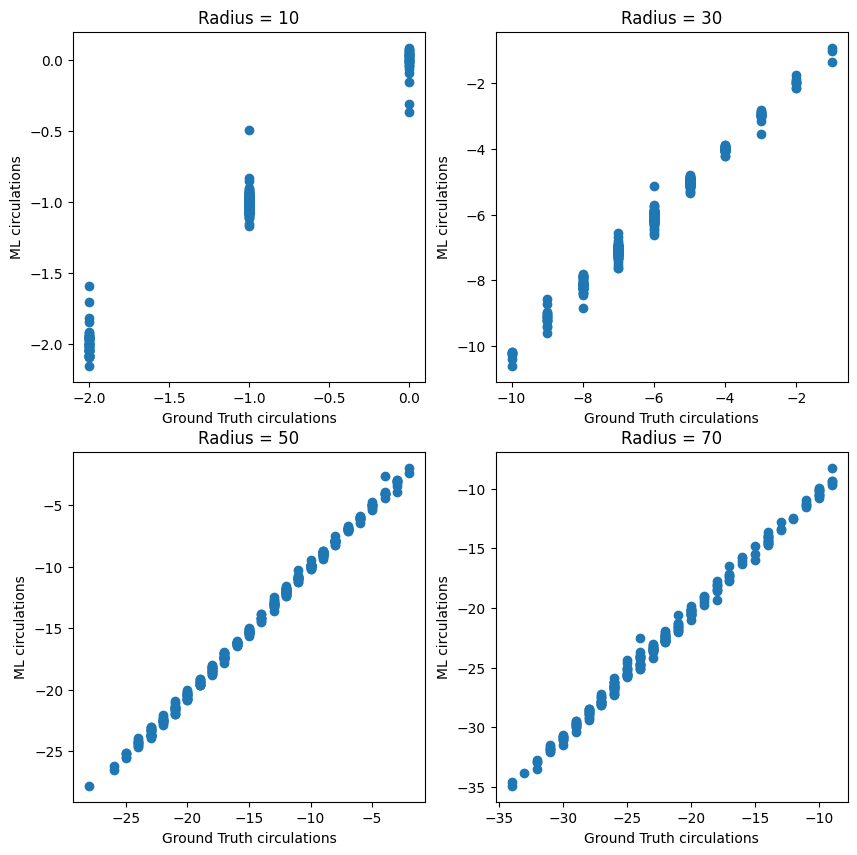

In [ ]:
radii = [10, 30, 50, 70]
fig, axes = plt.subplots(2, 2, figsize = (10, 10))

for r, ax in zip(radii, axes.flatten()):
    circle = draw_circle(100, 100, r)
    gt_circulations = find_path_integral(truths[:, 0, :, :], truths[:, 1, :, :], masks[:, 0, :, :], circle)
    ml_circulations = find_path_integral(predictions[:, 0, :, :], predictions[:, 1, :, :], masks[:, 0, :, :], circle)
    ax.scatter(gt_circulations / (2 * np.pi), ml_circulations / (2 * np.pi))
    ax.set_title(f"Radius = {r}")
    ax.set_xlabel("Ground Truth circulations")
    ax.set_ylabel("ML circulations")